## Реализация классификатора текста.
Необходимо обучить модель для определения жанра фильма по его краткому описанию.

Используем TensorFlow 2.0
Переключаемся на версию 2.0 (работает только в Colab)


In [49]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.13.0


## Загрузка библиотек
TensorFlow должен иметь как минимум версию 2.0

In [50]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

## Загрузка и чтение данных

In [51]:
# подключение к google диску
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# рабочая директория; при первом запуске создадим директорию (если её еще не существует),
# в противном случае надо заменить True на False
if True:
    !mkdir "/content/drive/My Drive/Classificator_for_text"
%cd "/content/drive/My Drive/Classificator_for_text"

mkdir: cannot create directory ‘/content/drive/My Drive/Classificator_for_text’: File exists
/content/drive/My Drive/Classificator_for_text


In [57]:
# загружаем данные (Genre_Classification_Dataset) в текущую рабочую директорию (Classificator_for_text)
if True:
    !7z x 14.18_Genre_Classification_Dataset.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 43185606 bytes (42 MiB)

Extracting archive: 14.18_Genre_Classification_Dataset.zip
--
Path = 14.18_Genre_Classification_Dataset.zip
Type = zip
Physical Size = 43185606

  0%      9% 1 - Genre Classification Dataset/train_data.txt                                                     19% 1 - Genre Classification Dataset/train_data.txt                                                     30% 1 - Genre Classification Dataset/train_data.txt                   

In [61]:
# посмотрим на содержимое файлов
descript = open('Genre Classification Dataset/description.txt',mode='rt')
descript_res = descript.readlines()
descript_res

['Train data:\n',
 'ID ::: TITLE ::: GENRE ::: DESCRIPTION\n',
 'ID ::: TITLE ::: GENRE ::: DESCRIPTION\n',
 'ID ::: TITLE ::: GENRE ::: DESCRIPTION\n',
 'ID ::: TITLE ::: GENRE ::: DESCRIPTION\n',
 '\n',
 'Test data:\n',
 'ID ::: TITLE ::: DESCRIPTION\n',
 'ID ::: TITLE ::: DESCRIPTION\n',
 'ID ::: TITLE ::: DESCRIPTION\n',
 'ID ::: TITLE ::: DESCRIPTION\n',
 '\n',
 'Source:\n',
 'ftp://ftp.fu-berlin.de/pub/misc/movies/database/']

In [63]:
train_data = open('Genre Classification Dataset/train_data.txt',mode='rt')
train_data = train_data.readlines()
train_data[:3]

['1 ::: Oscar et la dame rose (2009) ::: drama ::: Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.\n',
 '2 ::: Cupid (1997) ::: thriller ::: A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him.\n',
 '3 ::: Young, Wild and Wonderful (1980) ::: adult ::: As the bus empties the students for their field trip to the Museum of Natural History, little does the tour guide susp

In [64]:
test_data = open('Genre Classification Dataset/test_data.txt',mode='rt')
test_data = test_data.readlines()
test_data[:3]

["1 ::: Edgar's Lunch (1998) ::: L.R. Brane loves his life - his car, his apartment, his job, but especially his girlfriend, Vespa. One day while showering, Vespa runs out of shampoo. L.R. runs across the street to a convenience store to buy some more, a quick trip of no more than a few minutes. When he returns, Vespa is gone and every trace of her existence has been wiped out. L.R.'s life becomes a tortured existence as one strange event after another occurs to confirm in his mind that a conspiracy is working against his finding Vespa.\n",
 '2 ::: La guerra de papá (1977) ::: Spain, March 1964: Quico is a very naughty child of three belonging to a wealthy middle-class family. Since Cristina\'s birth, he feels he has lost the privileged position of "prince" of the house for his eight months old sister. So, with his brother Juan, who is eight years old and is quite disobedient, spend their time committing prank after prank, causing the resulting anger of his mother, the nanny and the ol

In [65]:
test_data_sol = open('Genre Classification Dataset/test_data_solution.txt',mode='rt')
test_data_sol = test_data_sol.readlines()
test_data_sol[:3]

["1 ::: Edgar's Lunch (1998) ::: thriller ::: L.R. Brane loves his life - his car, his apartment, his job, but especially his girlfriend, Vespa. One day while showering, Vespa runs out of shampoo. L.R. runs across the street to a convenience store to buy some more, a quick trip of no more than a few minutes. When he returns, Vespa is gone and every trace of her existence has been wiped out. L.R.'s life becomes a tortured existence as one strange event after another occurs to confirm in his mind that a conspiracy is working against his finding Vespa.\n",
 '2 ::: La guerra de papá (1977) ::: comedy ::: Spain, March 1964: Quico is a very naughty child of three belonging to a wealthy middle-class family. Since Cristina\'s birth, he feels he has lost the privileged position of "prince" of the house for his eight months old sister. So, with his brother Juan, who is eight years old and is quite disobedient, spend their time committing prank after prank, causing the resulting anger of his moth

## Предобработка данных

In [66]:
# преобразуем наши списковые данные в dataframe (трейновый датасет)

id_list = []
title = []
genre = []
descript = []

for line in train_data:
    line_row = line.split(':::')
    id_list.append(line_row[0].strip())
    title.append(line_row[1].strip())
    genre.append(line_row[2].strip())
    descript.append(line_row[3].strip())

train_df = pd.DataFrame({'id': id_list, 'title': title,
                         'genre': genre, 'descript': descript},
                        columns = ['id', 'title', 'genre', 'descript'])

print(train_df.shape)
train_df.head()

(54214, 4)


,id,title,genre,descript
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [67]:
# преобразуем наши списковые данные в dataframe (тестовый датасет)

id_list = []
title = []
genre = []
descript = []

for line in test_data_sol:
    line_row = line.split(':::')
    id_list.append(line_row[0].strip())
    title.append(line_row[1].strip())
    genre.append(line_row[2].strip())
    descript.append(line_row[3].strip())

test_df = pd.DataFrame({'id': id_list, 'title': title,
                        'genre': genre, 'descript': descript},
                       columns = ['id', 'title', 'genre', 'descript'])

print(test_df.shape)
test_df.head()

(54200, 4)


,id,title,genre,descript
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...


In [68]:
# жанры и их количество
print('genres of train_df')
print(train_df['genre'].unique())
print(train_df['genre'].nunique())
print('genres of test_df')
print(test_df['genre'].unique())
print(test_df['genre'].nunique())

genres of train_df
['drama' 'thriller' 'adult' 'documentary' 'comedy' 'crime' 'reality-tv'
 'horror' 'sport' 'animation' 'action' 'fantasy' 'short' 'sci-fi' 'music'
 'adventure' 'talk-show' 'western' 'family' 'mystery' 'history' 'news'
 'biography' 'romance' 'game-show' 'musical' 'war']
27
genres of test_df
['thriller' 'comedy' 'documentary' 'drama' 'horror' 'short' 'western'
 'family' 'sport' 'romance' 'war' 'game-show' 'biography' 'adult'
 'talk-show' 'action' 'music' 'crime' 'animation' 'sci-fi' 'adventure'
 'reality-tv' 'fantasy' 'mystery' 'history' 'news' 'musical']
27


In [69]:
def genres_to_numb(dataframe):
    dataframe['genre'] = dataframe['genre'].map({'drama': 0,
                                                 'thriller': 1,
                                                 'adult': 2,
                                                 'documentary': 3,
                                                 'comedy': 4,
                                                 'crime': 5,
                                                 'reality-tv': 6,
                                                 'horror': 7,
                                                 'sport': 8,
                                                 'animation': 9,
                                                 'action': 10,
                                                 'fantasy': 11,
                                                 'short': 12,
                                                 'sci-fi': 13,
                                                 'music': 14,
                                                 'adventure': 15,
                                                 'talk-show': 16,
                                                 'western': 17,
                                                 'family': 18,
                                                 'mystery': 19,
                                                 'history': 20,
                                                 'news': 21,
                                                 'biography': 22,
                                                 'romance': 23,
                                                 'game-show': 24,
                                                 'musical': 25,
                                                 'war': 26}).astype(int)

# genres of train_df в числа (27 категорий!)
genres_to_numb(train_df)

# genres of test_df в числа (27 категорий!)
genres_to_numb(test_df)

# pd.series to array
train_labels = train_df['genre'].to_numpy()
test_labels = test_df['genre'].to_numpy()

In [70]:
train_df.head(3)

,id,title,genre,descript
0,1,Oscar et la dame rose (2009),0,Listening in to a conversation between his doc...
1,2,Cupid (1997),1,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",2,As the bus empties the students for their fiel...


In [71]:
test_df.head(3)

,id,title,genre,descript
0,1,Edgar's Lunch (1998),1,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),4,"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),3,One year in the life of Albin and his family o...


In [72]:
import collections
import re

# pd.series to array
train_data = train_df['descript'].to_numpy()
test_data = test_df['descript'].to_numpy()

# tokenizer and vocab
TOKEN_RE = re.compile(r'[\w\d]+')

def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

# токенизация корпуса
def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

# добавление фейкового токена
def add_fake_token(word2id, token='<PAD>'):
    word2id_new = {token: i + 1 for token, i in word2id.items()}
    word2id_new[token] = 0
    return word2id_new

# тексты в токены
def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=10000, max_doc_freq=0.8,
                     min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq

# PAD_TOKEN = '__PAD__'
# NUMERIC_TOKEN = '__NUMBER__'
# NUMERIC_RE = re.compile(r'^([0-9.,e+\-]+|[mcxvi]+)$', re.I)

# def replace_number_nokens(tokenized_texts):
#     return [[token if not NUMERIC_RE.match(token) else NUMERIC_TOKEN for token in text]
#             for text in tokenized_texts]

In [73]:
train_tokenized = tokenize_corpus(train_data)
test_tokenized = tokenize_corpus(test_data)

print(' '.join(train_tokenized[0]))

listening conversation between doctor parents year oscar learns what nobody courage tell only weeks live furious refuses speak anyone except straight talking rose lady pink meets hospital stairs christmas approaches rose uses fantastical experiences professional wrestler imagination charm allow oscar live life love full company friends corn einstein bacon childhood sweetheart peggy blue


In [74]:
vocabulary, word_doc_freq = build_vocabulary(train_tokenized,
                                             max_doc_freq=0.8,
                                             min_count=5,
                                             pad_word='<PAD>')

UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 10000
[('<PAD>', 0), ('with', 1), ('that', 2), ('from', 3), ('their', 4), ('this', 5), ('they', 6), ('when', 7), ('life', 8), ('into', 9)]


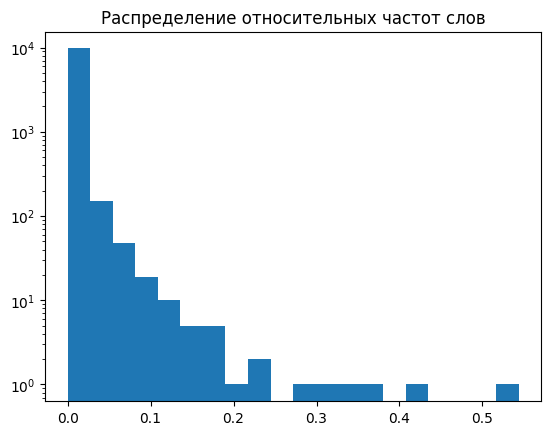

In [75]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [76]:
# numbers of tokens
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

4439 1702 48 490 188 44 2834 341 21 1832 1180 351 23 1024 71 3857 755 1201 663 1502 1296 1204 1599 716 4940 123 581 8255 1148 2348 1599 687 9309 456 598 8256 1624 3076 1559 2834 71 8 25 280 283 54 370 2534 8501 1155
156 209 1 108 150 11 730 3699 150 1381 103 8502 1381 103 332
398 4 1040 327 2089 812 125 128 111 717 1283 1453 2 398 37 29 62 49 112 717 31 74 7993 361 7559 9 226 39 2335 3151 2481 12 361 6 1060 3179 3151 39 2335 454 5387 9843 610 128 112 55 8790 21 5811 5388 76 271 485 107 717 38 9310 301 4763 768 937
64 4 2395 45 46 409 152 8647 1854 209 2090 56 9475 2090 179 3550 8257 9311 96 3551 1233 6671 3552 5688 992 7 4 45 2141 26 3502 6158 1134 152 8791 726 790 9844 2090 1942 726 179 25 1 8647 2130 2090 131 726 2 8647 437 523 2 209 13 107 362 29 2090 3725 1713 9311 1 235 32 209 726 567 2090 5387 110 8647 127 409 521 889 5876 437 3821 12 1088 8647 53 1631 726 236 2090 2765 222 487 4361 344 3350 359 285 10 1134 1043 12 3129 2090 118 726 8647 202
14 858 5168 23 4524 1316 1013 4557 34 

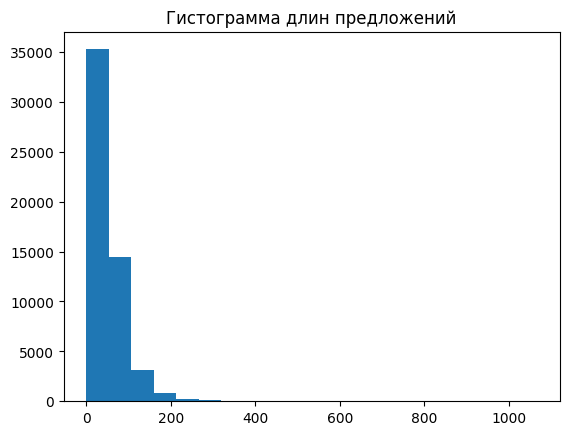

In [77]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [78]:
MAX_SEQ_LEN = 256 # Финальная длина последовательности

train_data = tf.keras.preprocessing.sequence.pad_sequences(
    train_token_ids,
    value=vocabulary["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

test_data = tf.keras.preprocessing.sequence.pad_sequences(
    test_token_ids,
    value=vocabulary["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

print("Length examples: {}".format([len(train_data[0]), len(train_data[1])]))
print('=====================================')
print("Entry example: {}".format(train_data[0]))

Length examples: [256, 256]
Entry example: [4439 1702   48  490  188   44 2834  341   21 1832 1180  351   23 1024
   71 3857  755 1201  663 1502 1296 1204 1599  716 4940  123  581 8255
 1148 2348 1599  687 9309  456  598 8256 1624 3076 1559 2834   71    8
   25  280  283   54  370 2534 8501 1155    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    

## Создание модели

In [79]:
EMB_SIZE = 32 # Размер векторного представления (эмбеддинга)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(UNIQUE_WORDS_N, 32),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(27, activation=tf.nn.softmax),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 27)                891       
                                                                 
Total params: 321947 (1.23 MB)
Trainable params: 321947 (1.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Подготовка модели к обучению

In [80]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

## Разбиение на обучающую и валидационную выборку


In [81]:
# валидационная выборка составит около 25%
border_split = int(train_df.shape[0]) - 13550

partial_x_train = train_data[:border_split]
x_val = train_data[border_split:]
partial_y_train = train_labels[:border_split]
y_val = train_labels[border_split:]

## Обучение модели

In [82]:
BATCH_SIZE = 256
NUM_EPOCHS = 26

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/26
159/159 [==============================] - 4s 22ms/step - loss: 2.7094 - acc: 0.2100 - val_loss: 2.3325 - val_acc: 0.3918
Epoch 2/26
159/159 [==============================] - 3s 18ms/step - loss: 2.3071 - acc: 0.3787 - val_loss: 2.2698 - val_acc: 0.4375
Epoch 3/26
159/159 [==============================] - 4s 26ms/step - loss: 2.2036 - acc: 0.4318 - val_loss: 2.1376 - val_acc: 0.4378
Epoch 4/26
159/159 [==============================] - 3s 21ms/step - loss: 2.0734 - acc: 0.4399 - val_loss: 2.0390 - val_acc: 0.4393
Epoch 5/26
159/159 [==============================] - 3s 18ms/step - loss: 1.9808 - acc: 0.4443 - val_loss: 1.9609 - val_acc: 0.4438
Epoch 6/26
159/159 [==============================] - 3s 18ms/step - loss: 1.8873 - acc: 0.4543 - val_loss: 1.8712 - val_acc: 0.4620
Epoch 7/26
159/159 [==============================] - 3s 21ms/step - loss: 1.7962 - acc: 0.4746 - val_loss: 1.8156 - val_acc: 0.4749
Epoch 8/26
159/159 [==============================] - 4s 26ms/step - 

# Оценка качества на тестовом датасете

In [83]:
results = model.evaluate(test_data, test_labels)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

1694/1694 [==============================] - 5s 3ms/step - loss: 1.6460 - acc: 0.5432
Test loss: 1.6460
Test accuracy: 54.32 %


Accuracy на тестовой выборке составляет 55%, что является очень хорошим результатом, т.к. у нас классификация идет на 27 категорий.

## Графики лосса и точности на обучающем и валидационном датасетах

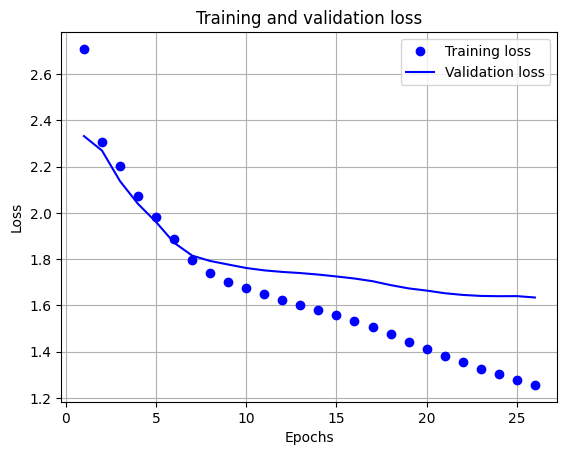

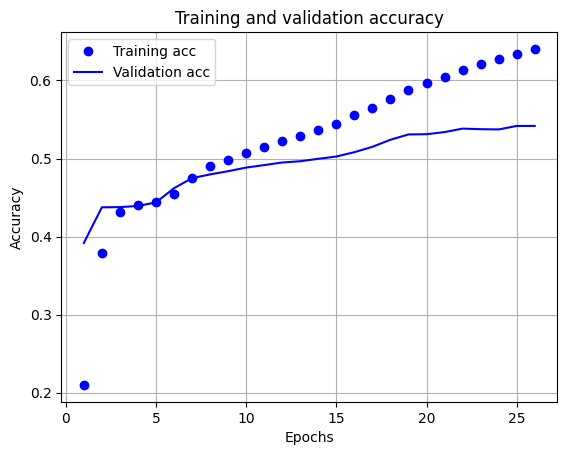

In [84]:
epochs = range(1, len(history.history['acc']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()